In [1]:
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

In [2]:
import os
from PIL import Image
from tensorflow.keras.utils import img_to_array

In [3]:
tumor = [('glioma_tumor', 0),('meningioma_tumor', 1),('no_tumor', 2),('pituitary_tumor', 3)]
path1 = 'Data/Training/'
path2 = 'Data/Testing/'

# Image Processing

In [4]:
Path = [
    'Data/Training/glioma_tumor/gg (104).jpg'  ,
    'Data/Training/meningioma_tumor/m (10).jpg',
    'Data/Training/no_tumor/image (12).jpg'    ,
    'Data/Training/pituitary_tumor/p (122).jpg',
]

In [5]:
def display (img_array) :
    
    dim = 10
    
    plt.figure(figsize  = (dim , dim))
    for i, img in enumerate(img_array) :
        plt.subplot(2, 2, i+1)
        plt.imshow(img,'gray')
        plt.title(img.shape)
        
    plt.show()

In [6]:
def get_array (path) :
    
    X = []
    y = []
    
    for typ, val in tumor :
        for image in os.listdir(path+typ) :
            img = cv2.resize(cv2.imread(path+typ+'/'+image, cv2.IMREAD_GRAYSCALE), (200,200))
            
            # create arrays
            X.append(img_to_array( Image.fromarray(img)))
            y.append(val)
    return X, y

In [7]:
image_array = []
for i, image_path in enumerate(Path) :
    image_array.append(cv2.resize(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), (200,200)))

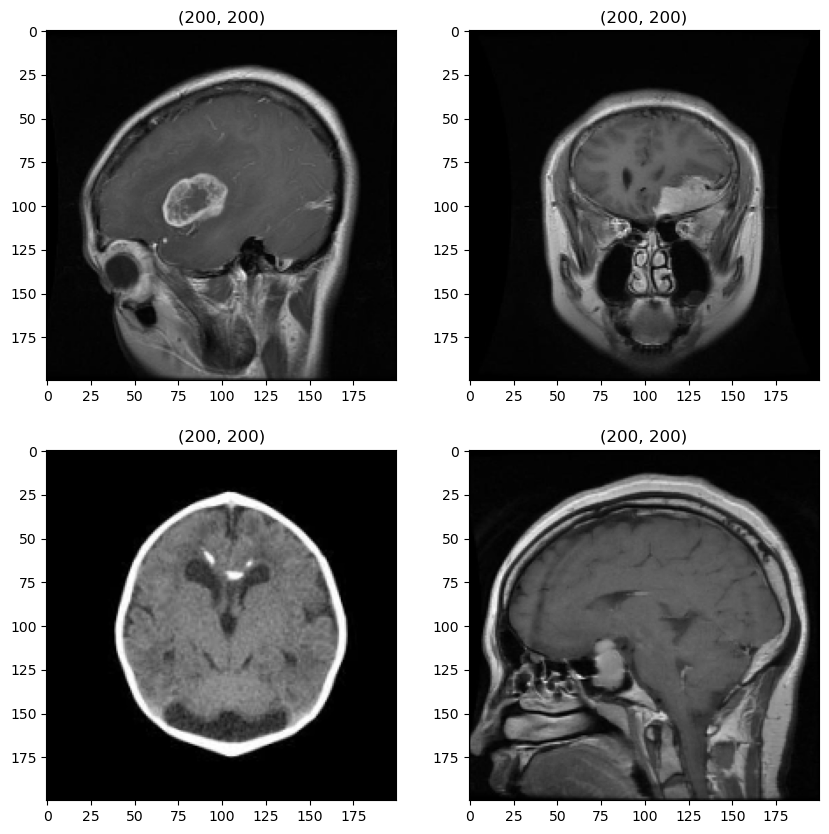

In [8]:
display(image_array)

# Convert Images to Numpy arrays

In [9]:
X_train, y_train = get_array(path1)

In [10]:
X_test , y_test  = get_array(path2)

In [11]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# Scale the arrays

In [12]:
X_train = np.array(X_train)
X_train/= 255.0

In [13]:
y_train = np.array(keras.utils.to_categorical(y_train))

In [14]:
X_test = np.array(X_test)
X_test/= 255.0

In [15]:
y_test = np.array(keras.utils.to_categorical(y_test))

In [16]:
print(X_train.shape)
print(y_train.shape)

(2870, 200, 200, 1)
(2870, 4)


In [17]:
print(X_test.shape)
print(y_test.shape)

(394, 200, 200, 1)
(394, 4)


In [18]:
info = {0 : 'Glioma tumor', 1 : 'Meningioma tumor', 2 : 'No tumor', 3 : 'Pituitary tumor'}

# Plots of some training samples

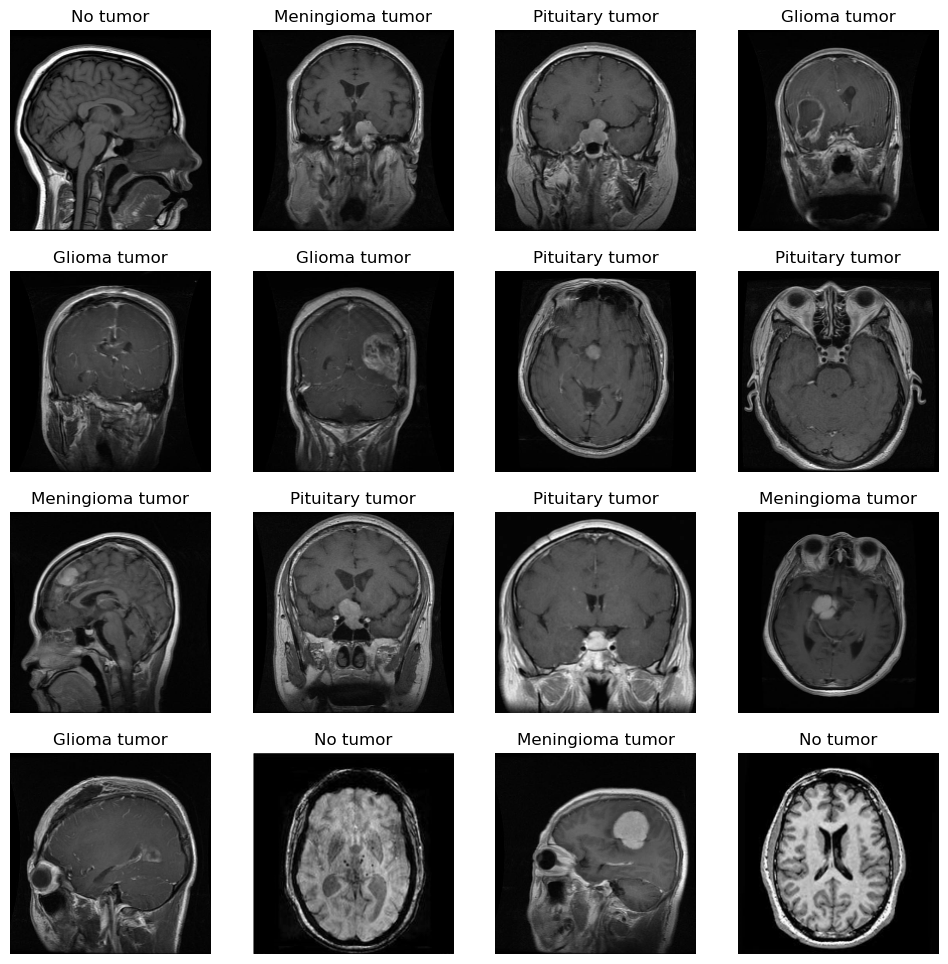

In [19]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(0, 2870)
    plt.imshow(X_train[x], 'gray')
    plt.title(info[np.argmax(y_train[x])])
    plt.axis('off')
plt.show()

# Class frequency distribution

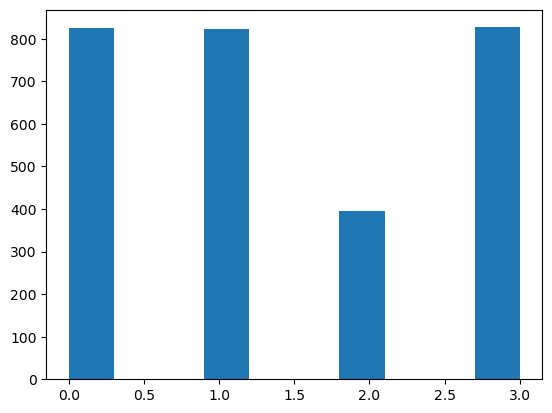

In [20]:
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

# Synthetic Minority Oversampling
**Glioma tumor, Meningioma tumor** and **Pituitary tumor** almost same number of datasets ie. 826, 822 and 827 respectively. But the label **no_tumor** has only 395 samples. Since the number of samples for **no_tumor** class is less, let's oversample that class using SMOTE from imblearn package.

In [21]:
print(X_train.shape)
print(y_train.shape)

(2870, 200, 200, 1)
(2870, 4)


In [22]:
X_train = np.reshape(X_train, (2870, 200*200*1))
print(X_train.shape)
print(y_train.shape)

(2870, 40000)
(2870, 4)


In [23]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state = 1, k_neighbors = 5).fit_resample(X_train, y_train)

In [24]:
print(X_train.shape)
print(y_train.shape)

(3308, 40000)
(3308, 4)


In [25]:
X_train = np.reshape(X_train, (3308, 200, 200, 1))
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308, 4)


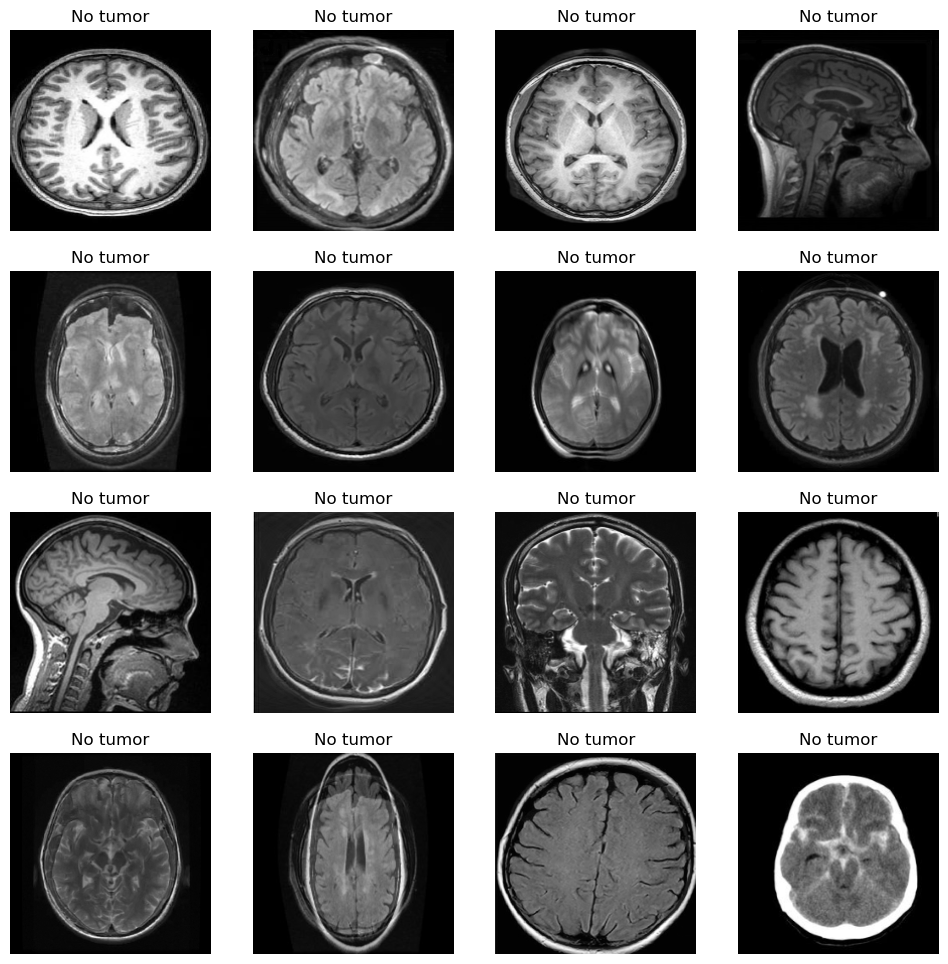

In [26]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(2870, 3308)
    plt.imshow(X_train[x], 'gray')
    plt.title(info[np.argmax(y_train[x])])
    plt.axis('off')
plt.show()

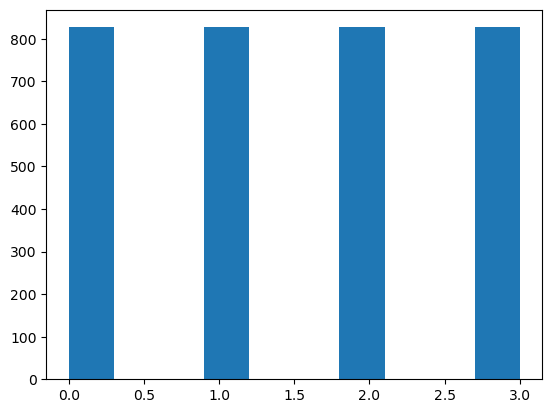

In [27]:
plt.hist(np.argmax(y_train, axis = 1))
plt.show()

# Images of test samples

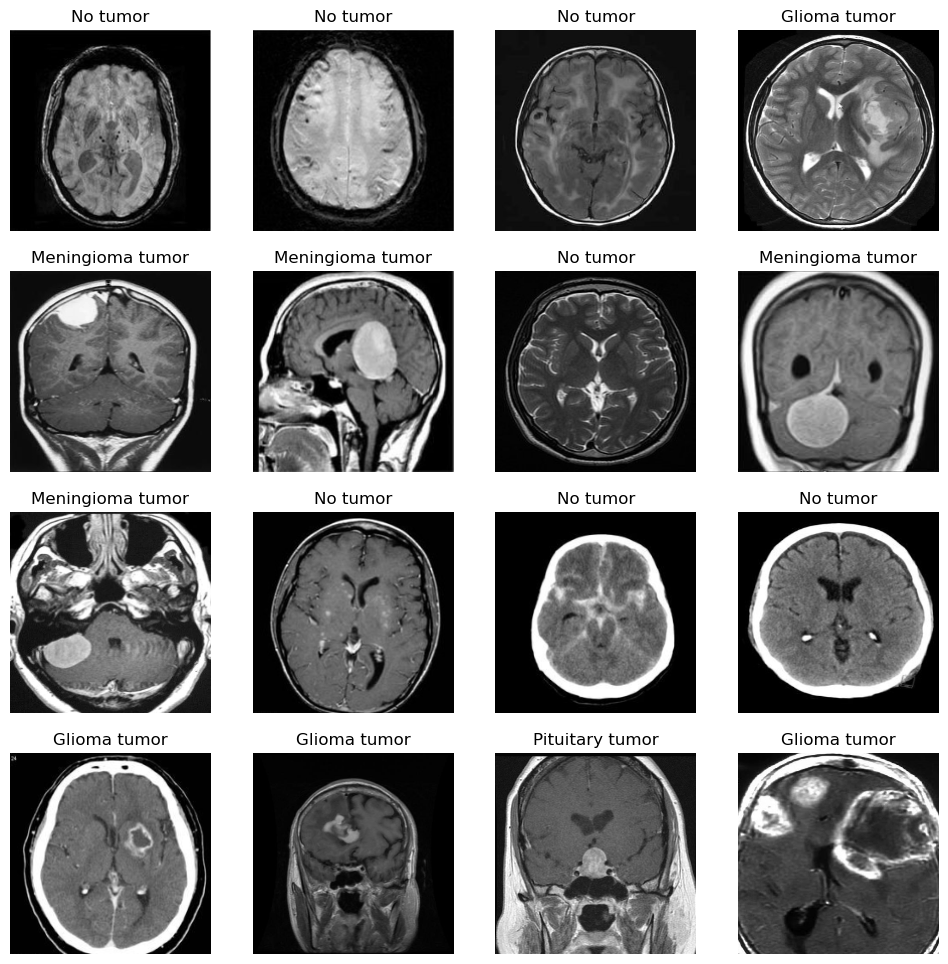

In [28]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    x = np.random.randint(0,390)
    plt.imshow(X_test[x],'gray')
    plt.title(info[np.argmax(y_test[x])])
    plt.axis('off')
plt.show()

# Model creation and training

In [29]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Conv2D

In [30]:
def conv_layer (filterx) :
    
    model = Sequential()
    model.add(Conv2D(filterx, (3,3), padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid'))
    model.add(BatchNormalization())
    
    return model

In [31]:
def dens_layer (hiddenx) :
    
    model = Sequential()
    model.add(Dense(hiddenx, activation = 'relu', kernel_regularizer = 'l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    return model

In [32]:
def cnn (filter1, filter2, filter3, hidden1, hidden2) :
    
    model = Sequential()
    
    model.add(Input((200,200,1,)))
    model.add(conv_layer(filter1))
    model.add(conv_layer(filter2))
    model.add(conv_layer(filter3))
    
    model.add(Flatten())
    model.add(dens_layer(hidden1))
    model.add(dens_layer(hidden2))
    model.add(Dense(4, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])
    
    return model

# Use ImageDataGenerator for image data augmentation

In [33]:
print(X_train.shape)
print(y_train.shape)

(3308, 200, 200, 1)
(3308, 4)


In [34]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(zoom_range = [0.85, 1.0], rotation_range = 3)

In [35]:
gen.fit(X_train)
train_gen = gen.flow(X_train, y_train, batch_size = 32)

In [36]:
trainX, trainy = train_gen.next()

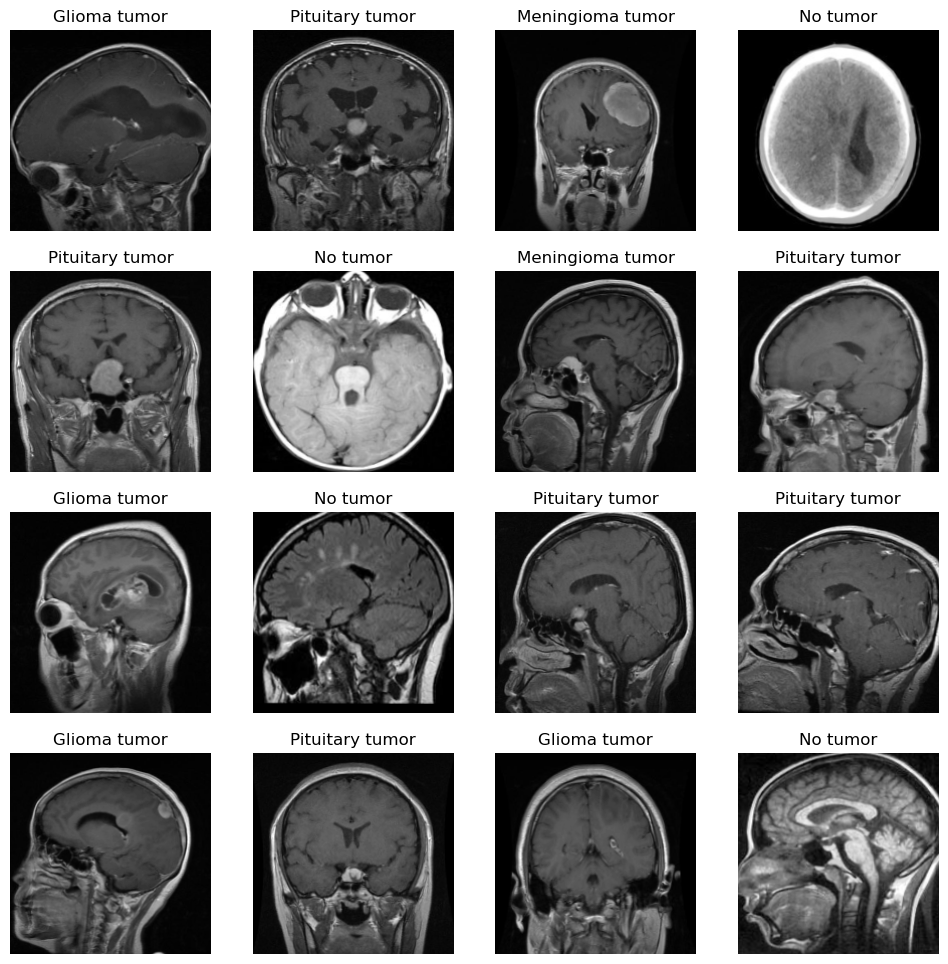

In [37]:
plt.figure(figsize = (12,12))
for i in range(16) :
    plt.subplot(4, 4, i+1)
    plt.imshow(trainX[i], 'gray')
    plt.title(info[np.argmax(trainy[i])])
    plt.axis('off')
plt.show()

## Model implementation

In [39]:
from keras.callbacks import ModelCheckpoint
checkp = ModelCheckpoint('Model/brain_model.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)

In [40]:
model = cnn(128, 64, 32, 128, 64)

In [41]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100, 100, 128)     1792      
                                                                 
 sequential_2 (Sequential)   (None, 50, 50, 64)        74048     
                                                                 
 sequential_3 (Sequential)   (None, 25, 25, 32)        18592     
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 sequential_4 (Sequential)   (None, 128)               2560640   
                                                                 
 sequential_5 (Sequential)   (None, 64)                8512      
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [42]:
history = model.fit(gen.flow(X_train, y_train, batch_size = 32), epochs = 100, validation_data = (X_test,y_test), callbacks = [checkp])

Epoch 1/100
104/104 [==============================] - ETA: 0s - loss: 4.2642 - accuracy: 0.6675
Epoch 1: val_accuracy improved from -inf to 0.26650, saving model to Model\brain_model.h5
104/104 [==============================] - 20s 127ms/step - loss: 4.2642 - accuracy: 0.6675 - val_loss: 6.0621 - val_accuracy: 0.2665
Epoch 2/100
104/104 [==============================] - ETA: 0s - loss: 3.8133 - accuracy: 0.7996
Epoch 2: val_accuracy did not improve from 0.26650
104/104 [==============================] - 12s 116ms/step - loss: 3.8133 - accuracy: 0.7996 - val_loss: 6.3033 - val_accuracy: 0.2665
Epoch 3/100
104/104 [==============================] - ETA: 0s - loss: 3.5459 - accuracy: 0.8476
Epoch 3: val_accuracy did not improve from 0.26650
104/104 [==============================] - 12s 116ms/step - loss: 3.5459 - accuracy: 0.8476 - val_loss: 7.0119 - val_accuracy: 0.2665
Epoch 4/100
104/104 [==============================] - ETA: 0s - loss: 3.3534 - accuracy: 0.8619
Epoch 4: val_accur

Epoch 28/100
104/104 [==============================] - ETA: 0s - loss: 0.8122 - accuracy: 0.9680
Epoch 28: val_accuracy did not improve from 0.73858
104/104 [==============================] - 12s 118ms/step - loss: 0.8122 - accuracy: 0.9680 - val_loss: 2.1815 - val_accuracy: 0.7157
Epoch 29/100
104/104 [==============================] - ETA: 0s - loss: 0.7775 - accuracy: 0.9707
Epoch 29: val_accuracy did not improve from 0.73858
104/104 [==============================] - 12s 118ms/step - loss: 0.7775 - accuracy: 0.9707 - val_loss: 2.0350 - val_accuracy: 0.7183
Epoch 30/100
104/104 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.9767
Epoch 30: val_accuracy did not improve from 0.73858
104/104 [==============================] - 12s 118ms/step - loss: 0.7306 - accuracy: 0.9767 - val_loss: 2.1189 - val_accuracy: 0.7360
Epoch 31/100
104/104 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.9767
Epoch 31: val_accuracy did not improve from 0.7385

Epoch 57/100
104/104 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.9791
Epoch 57: val_accuracy did not improve from 0.74619
104/104 [==============================] - 12s 120ms/step - loss: 0.3658 - accuracy: 0.9791 - val_loss: 2.1118 - val_accuracy: 0.7081
Epoch 58/100
104/104 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.9807
Epoch 58: val_accuracy did not improve from 0.74619
104/104 [==============================] - 13s 122ms/step - loss: 0.3670 - accuracy: 0.9807 - val_loss: 2.1452 - val_accuracy: 0.7132
Epoch 59/100
104/104 [==============================] - ETA: 0s - loss: 0.3800 - accuracy: 0.9785
Epoch 59: val_accuracy did not improve from 0.74619
104/104 [==============================] - 12s 119ms/step - loss: 0.3800 - accuracy: 0.9785 - val_loss: 2.0808 - val_accuracy: 0.6954
Epoch 60/100
104/104 [==============================] - ETA: 0s - loss: 0.3537 - accuracy: 0.9858
Epoch 60: val_accuracy did not improve from 0.7461

Epoch 86/100
104/104 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9885
Epoch 86: val_accuracy did not improve from 0.74873
104/104 [==============================] - 13s 120ms/step - loss: 0.2630 - accuracy: 0.9885 - val_loss: 1.5770 - val_accuracy: 0.7234
Epoch 87/100
104/104 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9861
Epoch 87: val_accuracy did not improve from 0.74873
104/104 [==============================] - 13s 123ms/step - loss: 0.2708 - accuracy: 0.9861 - val_loss: 1.9519 - val_accuracy: 0.6624
Epoch 88/100
104/104 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.9840
Epoch 88: val_accuracy did not improve from 0.74873
104/104 [==============================] - 12s 120ms/step - loss: 0.2846 - accuracy: 0.9840 - val_loss: 1.7330 - val_accuracy: 0.7132
Epoch 89/100
104/104 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9846
Epoch 89: val_accuracy did not improve from 0.7487

Text(0.5, 1.0, 'Loss vs Epochs')

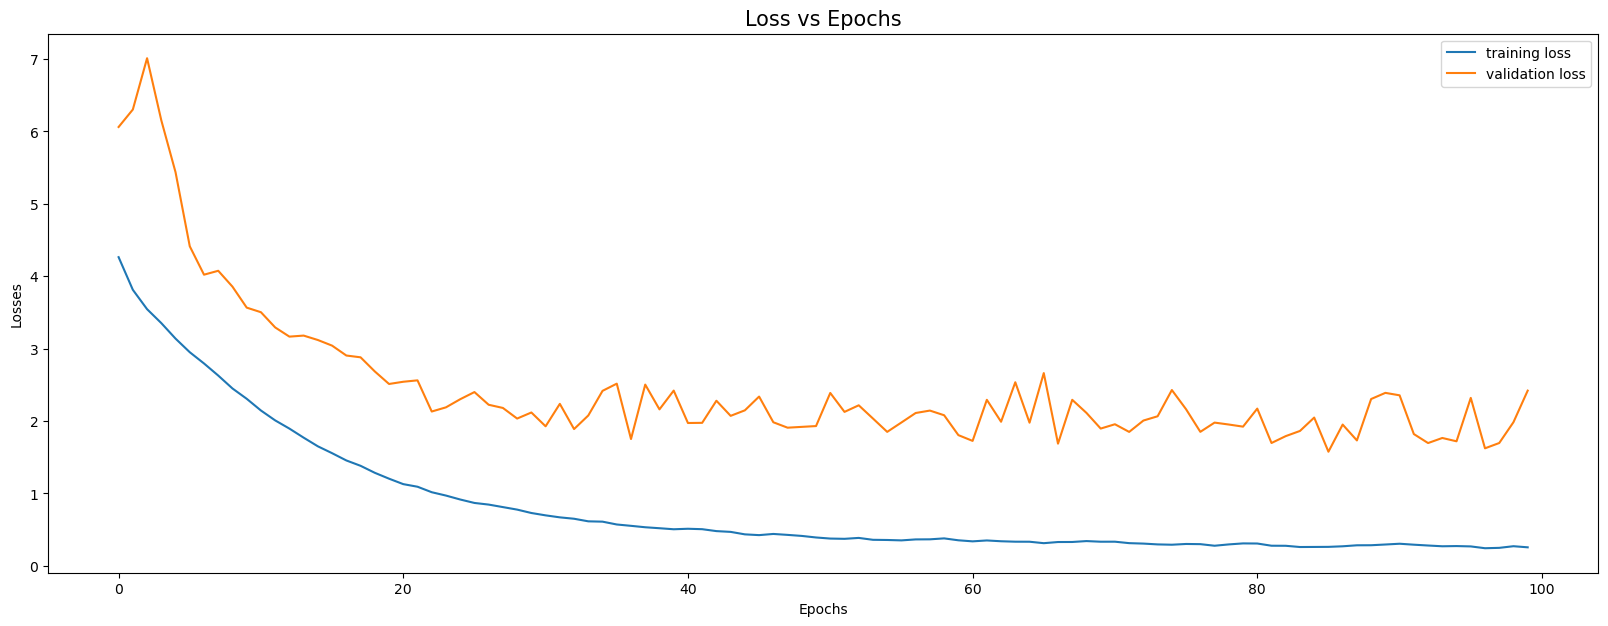

In [44]:
plt.figure(figsize = (20,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss vs Epochs', fontsize = 15)

Text(0.5, 1.0, 'Accuracy vs Epochs')

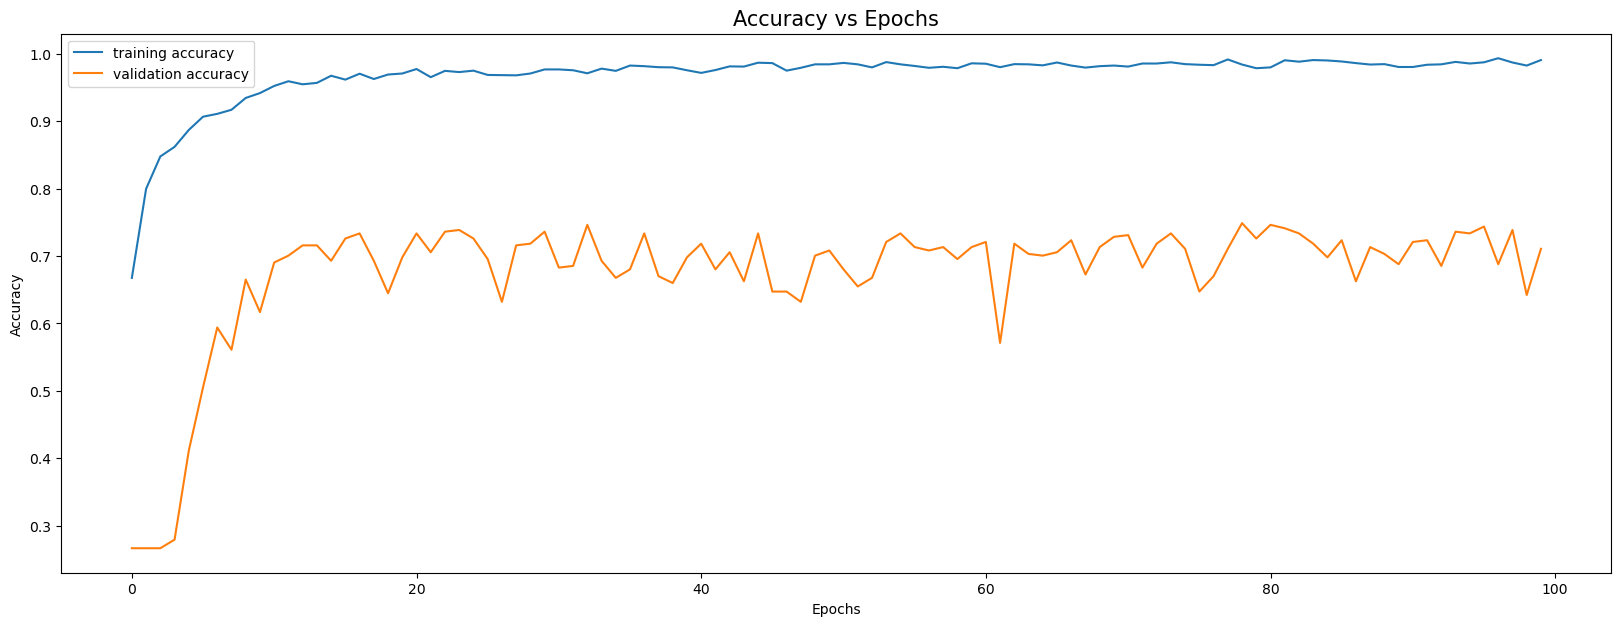

In [45]:
plt.figure(figsize = (20,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs', fontsize = 15)

# Prediction

In [47]:
from keras.models import load_model
model = load_model('Model/brain_model.h5')

In [48]:
pred = model.predict(X_test)

13/13 [==============================] - 1s 44ms/step


In [49]:
print(pred[0:3,:])

[[0.14946494 0.05997902 0.70174193 0.08881414]
 [0.04691851 0.91846216 0.03240344 0.00221582]
 [0.00324072 0.01041498 0.9821224  0.00422198]]


In [50]:
temp = np.argmax(pred, axis = 1)
pred = np.zeros(pred.shape)

In [51]:
pred[np.arange(pred.shape[0]), temp] = 1

In [54]:
print(pred[0:3,:])
print(y_test[0:3,:])

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [53]:
from sklearn.metrics import accuracy_score, classification_report
print('Accuracy : ' + str(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred, target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']))

Accuracy : 0.748730964467005
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.20      0.33       100
meningioma_tumor       0.76      0.92      0.83       115
        no_tumor       0.67      0.98      0.80       105
 pituitary_tumor       0.82      0.89      0.86        74

       micro avg       0.75      0.75      0.75       394
       macro avg       0.79      0.75      0.70       394
    weighted avg       0.79      0.75      0.70       394
     samples avg       0.75      0.75      0.75       394

